In [1]:
import matplotlib.pyplot as pp
import pycbc.noise
import pycbc.psd
import pycbc.filter
from pycbc.waveform import get_td_waveform
from pycbc.waveform import get_fd_waveform
import numpy as np
from pycbc.vetoes import power_chisq
from pycbc.events.ranking import newsnr
import pandas as pd
from pycbc.filter import sigma
import h5py


PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


In [2]:
def gen_noise():
    
    # The color of the noise matches a PSD which you provide
    flow = 30.0
    delta_f = 1.0 / 16
    flen = int(2048 / delta_f) + 1
    psd = pycbc.psd.aLIGOZeroDetHighPower(flen, delta_f, flow)

   

    # Generate 256 seconds of noise at 4096 Hz
    delta_t = 1.0 / 4096
    tsamples = int(256/ delta_t)
    ts = pycbc.noise.gaussian.noise_from_psd(tsamples,delta_t, psd, seed=127)
    
   

    return ts

In [3]:
def gen_waveform(model,m1,m2,s1z,s2z,distance,time,l):
    
    from pycbc.detector import Detector
    from pycbc.waveform import get_td_waveform

    ra = 1.7
    dec = 1.7
    pol = 0.2
    inclination_1 = 0
    d = Detector("H1")

   
    fp, fc = d.antenna_pattern(ra, dec, pol, time)
    hp_1, hc_1 = get_td_waveform(approximant=model,
                             mass1=m1, mass2=m2,spin1z=s1z,spin2z=s2z,
                             distance=distance, inclination=inclination_1,
                             delta_t=1.0/4096, f_lower=30)

    ht_1 = fp * hp_1 + fc * hc_1

    return ht_1

In [4]:
def overlap(ht_1,ht_2,buffer):

    if len(ht_1) < len(ht_2):
        ht_small, ht_big = ht_1, ht_2
    else:
        ht_small, ht_big = ht_2, ht_1

    dt = ht_small.delta_t

    # make buffer int multiple of dt
    buffer = np.round(buffer*ht_big.sample_rate)/ht_big.sample_rate
    # elongate the long template to accomodate enough space on left
    ht_big.resize(len(ht_big)+int(buffer*ht_big.sample_rate))
    # match small template
    ht_small.resize(len(ht_big))
    # correct the position after resizing
    ht_big = ht_big.cyclic_time_shift(buffer)
    #Shifting the merger time
    ht_small = ht_small.cyclic_time_shift(ht_small.start_time-ht_big.start_time-buffer)
    #Equating the start time of both signals
    ht_small.start_time = ht_big.start_time
    # resample to original sample rate
    ht_big = ht_big.resample(dt)
    ht_small = ht_small.resample(dt)

    #Combining the signals
    ht_total = ht_small + ht_big

    return ht_total,ht_2

In [5]:
def inject(ht_total,ts,injtime):

    # append extra zeros than required
    ht_total.append_zeros(int((ts.duration-injtime)*1.2*4096))

    ht_total = ht_total.cyclic_time_shift(int(injtime + ht_total.start_time))
    ht_total = ht_total.resample(ts.delta_t)

    #Resizing the signal
    ht_total.resize(len(ts))

    #Equating the start time
    ht_total.start_time = ts.start_time

    #Injecting signal into noise
    ts = ts.add_into(ht_total)

    #plotting the result
    # pp.plot(ts.sample_times, ts)
    # pp.xlabel('Time(s)')
    # pp.ylabel('Strain')
    # pp.grid()
    # pp.show()

    return ts

In [6]:
def psd_data(conditioned):

    from pycbc.psd import interpolate, inverse_spectrum_truncation
    # Estimate the power spectral density

    # We use 4 second samples of our time series in Welch method.
    psd = conditioned.psd(4)

    # Now that we have the psd we need to interpolate it to match our data
    # and then limit the filter length of 1 / PSD. After this, we can
    # directly use this PSD to filter the data in a controlled manner

    psd = interpolate(psd, conditioned.delta_f)

    # 1/PSD will now act as a filter with an effective length of 4 seconds
    # Since the data has been highpassed above 30 Hz, and will have low values
    # below this we need to informat the function to not include frequencies
    # below this frequency. 
    psd = inverse_spectrum_truncation(psd, int(4 * conditioned.sample_rate),
                                      low_frequency_cutoff=30)

#     pp.loglog(psd.sample_frequencies, psd)
#     pp.ylabel('$Strain^2 / Hz$')
#     pp.xlabel('Frequency (Hz)')
#     pp.xlim(30, 1024)
    
    return psd

In [7]:
def template_bank(m_1,m_2,m_radius,temp_numb):

    # Generate templates for BNS
    temp_bank = np.zeros((temp_numb, 2))
    for i in range(temp_numb):
        r1 = np.random.uniform(0,m_radius)
        r2 = np.random.uniform(0,(np.pi*2))           
        m1 = r1*(np.cos(r2)) + m_1
        m2 = r1*(np.sin(r2)) + m_2

        temp_bank[i, :] = [m1, m2]

    temp_bank[i,:] = [m_1,m_2]
    
    return temp_bank

In [8]:
def gen_template(model,m1,m2,s1z,s2z,conditioned):
    
    from pycbc.detector import Detector
    from pycbc.waveform import get_td_waveform

    
    ra = 1.7
    dec = 1.7
    pol = 0.2
    inclination_1 = 0
    time=0.0



    # We can calcualate the antenna pattern for Hanford at
    # the specific sky location
    d = Detector("H1")

    # We get back the fp and fc antenna pattern weights.
    fp, fc = d.antenna_pattern(ra, dec, pol, time)
    
    
    
    hp, hc = get_td_waveform(approximant=model,
                     mass1=m1,
                     mass2=m2,spin1z=s1z,spin2z=s2z,
                     delta_t=conditioned.delta_t,
                     f_lower=30)
    
    
    ht_template = fp * hp + fc * hc
    
    #Resizing the template to match data
    ht_template.resize(len(conditioned))
    
    #Time shift 
    template = ht_template.cyclic_time_shift(ht_template.start_time)
    
   
    return template

In [9]:
#Constructing data and template bank

In [10]:
noise = gen_noise()

bbh_templates = template_bank(20,30,10,6)

bns_templates = template_bank(1.3,1.4,0.25,6)

bank_total = np.concatenate([bbh_templates,bns_templates])

In [11]:
tab = []

for i in range(1):
    
    print("Injection number:",i)
    print(' ')

    i1 = int(np.random.randint(low = 0,high = 6,size = 1))
    i2 = int(np.random.randint(low = 0,high = 6,size = 1))
    m1_1 = bbh_templates[i1][0]
    m2_1 = bbh_templates[i1][1]
    m1_2 = bns_templates[i2][0]
    m2_2 = bns_templates[i2][1]

    buffer = np.random.uniform(0.1,1.8)


    h1_bbh = gen_waveform('IMRPhenomPv2',m1_1,m2_1,0.0,0.0,50,0.0,"BBH")

    h1_bns = gen_waveform('TaylorF2',m1_2,m2_2,0.0,0.0,2,0.0,"BNS")

    ht_total,h1_bbh = overlap(h1_bbh,h1_bns,buffer)

    ts1 = inject(ht_total,noise,100)
    ts1.save(f"Signals_BBH_BNS/Data_{i}.hdf")

    print(m1_1,',',m2_1)
    print(m1_2,',',m2_2)
    print(buffer)
    print(' ')
    print('-------------------------------------------------------------------')
    
    tab.append([m1_1,m2_1,m1_2,m2_2,buffer])

Injection number: 0
 
23.963197990653473 , 26.059224598128225
1.2785395505632264 , 1.444743830067412
1.6277476539791673
 
-------------------------------------------------------------------


In [12]:
for i in range(6):
    T1 = gen_template('IMRPhenomPv2',bbh_templates[i][0],bbh_templates[i][1],0.0,0.0,ts1)
    T1.save(f"Signals_BBH_BNS/signal_bbh{i}.hdf")
    T2 = gen_template('TaylorF2',bns_templates[i][0],bns_templates[i][1],0.0,0.0,ts1)
    T2.save(f"Signals_BBH_BNS/signal_bns{i}.hdf")

In [13]:
temp_bank = pd.DataFrame(bank_total)
temp_bank.to_csv('Signals_BBH_BNS/Load_bbh_bns.csv',index = False)

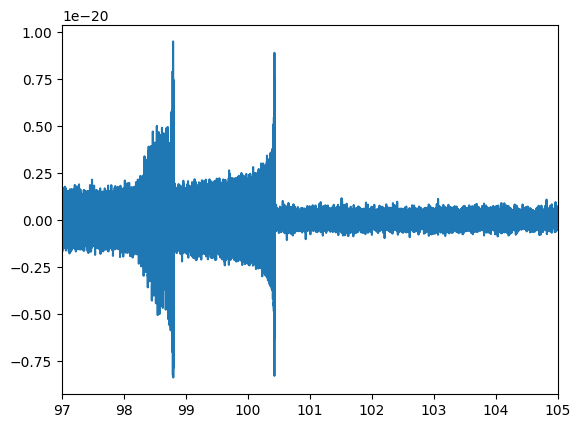

In [16]:
pp.plot(ts1.sample_times,ts1)
pp.xlim(97,105)
pp.show()

In [15]:
temp_bank

,0,1
0,16.068173,29.182342
1,23.963198,26.059225
2,22.426519,34.545260
3,29.054320,26.925880
4,15.309060,33.740029
5,20.000000,30.000000
6,1.336704,1.385425
7,1.243198,1.561168
8,1.293314,1.415998
9,1.278540,1.444744
